<a href="https://colab.research.google.com/github/CYaiche/Machine_Learning/blob/master/projet5/embedding_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Supervised topic modeling : NN approach



In [1]:
from  tm_common import *
IN_COLAB, output_dir = tm_get_working_config()
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim.corpora as corpora
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from sklearn.preprocessing import MultiLabelBinarizer
from keras.utils import pad_sequences
from sklearn.metrics import jaccard_score, average_precision_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Flatten,
    Embedding,
    Dense,
    Input,
    Embedding,
    GlobalAveragePooling1D,
)

from sentence_transformers import SentenceTransformer

c:\dev\topic_modelling\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Python version used : ", sys.version[:7])
print("Tensorflow  : ", tf.version.VERSION)

Python version used :  3.8.10 
Tensorflow  :  2.10.1


In [3]:
X_train, X_test, y_train, y_test = tm_load_train_test_set(output_dir)

X_corpus_train, X_corpus_test = tm_load_train_test_set(output_dir, option="raw_corpus")
label_list = tm_get_label_list(output_dir)

In [4]:
X_train, y_train = tm_get_subset(X_train, y_train)
X_test, y_test = tm_get_subset(X_test, y_test)
X_corpus_train, X_corpus_test = tm_get_subset(X_corpus_train, X_corpus_test)

In [5]:
y_train_b, y_test_b = tm_multilabel_binarizer(y_train, y_test)

# Neural Networks

Multilayers perceptron (MLP) for multi-label classification

loss funstion : binary cross-entropy loss function

activation function : ReLU in the hidden layers

adam version of stochastic gradient descent

# Embedding preprocessing

In [6]:
X_train_list = [ x.tolist() for x in X_train]

In [7]:
#  Word2Vec model creation
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences

sentences = X_train_list

print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)

Build & train Word2Vec model ...


The reason for separating the trained vectors into KeyedVectors is that if you don’t need the full model state any more (don’t need to continue training), the state can discarded, resulting in a much smaller and faster object that can be mmapped for lightning fast loading and sharing the vectors in RAM between processes:

Gensim can also load word vectors in the “word2vec C format”, as a KeyedVectors instance:

In [8]:
try:
    model_vectors = KeyedVectors.load(f"{output_dir}model_vector.wv", mmap="r")
except:
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv

    model_vectors.save(f"{output_dir}model_vector.wv")

In [9]:
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 370103
Word2Vec trained


In [10]:
print(w2v_model)

Word2Vec<vocab=0, vector_size=300, alpha=0.025>


In [11]:
d = dict(zip(label_list, range(0,len(label_list))))

In [12]:
id2word = corpora.Dictionary(X_train)
x_train_ids = [ id2word.doc2idx(tokens) for tokens in X_train]

x_test_ids = [ id2word.doc2idx(tokens) for tokens in X_test  ]
# Filter out -1 from x_test_ids
filtered_x_test_ids = [[word_id for word_id in sentence if word_id != -1] for sentence in x_test_ids]



In [13]:
max_length = np.max([ len(x) for x in x_train_ids])
print(f"max_length : {max_length}")

max_length : 1862


# Embedding matrix

In [14]:
len(model_vectors[0])

300

In [15]:
word2vec_vocab_size = len(model_vectors.key_to_index)
w2vec_dim = len(model_vectors[0])
word2vec_embedding_matrix = np.zeros((word2vec_vocab_size, w2vec_dim))

for word in model_vectors.key_to_index:
    embedding_vector = model_vectors[word]
    if embedding_vector is not None:
        idx = model_vectors.key_to_index[word]
        word2vec_embedding_matrix[idx] = embedding_vector

print("Embedding matrix: %s" % str(word2vec_embedding_matrix.shape))

Embedding matrix: (370103, 300)


# Apply padding

In [16]:
x_train_pad = pad_sequences(x_train_ids, maxlen=max_length, padding='pre',value=0)
x_test_pad = pad_sequences(filtered_x_test_ids, maxlen=max_length, padding='pre',value=0)


In [17]:
model = Sequential()
# model.add(Input(shape=(1,max_length),dtype='float64'))
model.add(Embedding( word2vec_vocab_size, w2vec_dim,weights=[word2vec_embedding_matrix],  input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(30,activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1862, 300)         111030900 
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 30)                9030      
                                                                 
Total params: 111,039,930
Trainable params: 111,039,930
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
model.fit(x_train_pad, y_train_b, batch_size=128, epochs=50)

Epoch 1/50
49/49 [==============================] - 59s 1s/step - loss: 0.2846 - accuracy: 0.1246
Epoch 2/50
 2/49 [>.............................] - ETA: 51s - loss: 0.2012 - accuracy: 0.1562

In [ ]:
y_pred = model.predict(x_train_pad)
threshold_test = tm_test_threshold(y_train_b, y_pred)  


  1/194 [..............................] - ETA: 13s

194/194 [==============================] - 4s 21ms/step


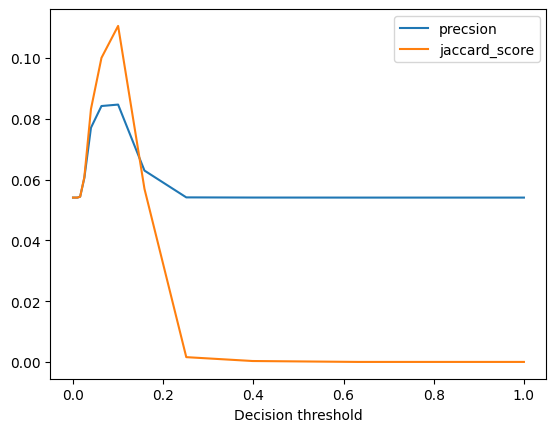

In [ ]:
tm_plot_threshold_test(threshold_test)

In [ ]:

max_config = threshold_test.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]

best_t

0.09999999999999346

In [ ]:
y_pred = model.predict(x_test_pad)
y_pred_nn = (y_pred > best_t).astype(np.float32)

49/49 [==============================] - 2s 33ms/step


In [ ]:

precision_w2v      = average_precision_score(y_test_b, y_pred_nn, average='micro')
jaccard_score_w2v = jaccard_score(y_test_b, y_pred_nn, average='micro')

The vocab is the number of unique words in my train data.
The size is the dimension in output of my embedding.

In [ ]:
plot_confusion_matrix(y_test_b, y_pred_nn, label_list)

In [ ]:
ethqetjsryjsrytk

# USE : Universal Sentence Encoder 
encodes into high-dimensional vectors, trained on variety of data and output 512 dimensional vector

# apply padding to words 

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
X_train_use_embedding = embed(X_corpus_train.tolist())
X_test_use_embedding = embed(X_corpus_test.tolist())

In [ ]:
use_model = Sequential()
use_model.add(Dense(256, activation='relu', input_dim=512))
use_model.add(Dense(128, activation='relu'))
use_model.add(Dense(30,activation='sigmoid'))
# Compile the model
use_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
use_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 30)                3870      
                                                                 
Total params: 168,094
Trainable params: 168,094
Non-trainable params: 0
_________________________________________________________________


In [ ]:
use_model.fit(X_train_use_embedding, y_train_b, batch_size = 128, epochs=50)

Epoch 1/100


49/49 [==============================] - 0s 4ms/step - loss: 0.0488 - accuracy: 0.7633
Epoch 2/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0481 - accuracy: 0.7679
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0473 - accuracy: 0.7669
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0466 - accuracy: 0.7690
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0458 - accuracy: 0.7698
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0450 - accuracy: 0.7700
Epoch 7/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.7726
Epoch 8/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0433 - accuracy: 0.7729
Epoch 9/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0428 - accuracy: 0.7766
Epoch 10/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 0.7771
Epoch 11/100
49/49 [=

In [ ]:
y_pred = use_model.predict(X_train_use_embedding[:100])
threshold_test_use = tm_test_threshold(y_train_b[:100], y_pred)  

4/4 [==============================] - 0s 3ms/step


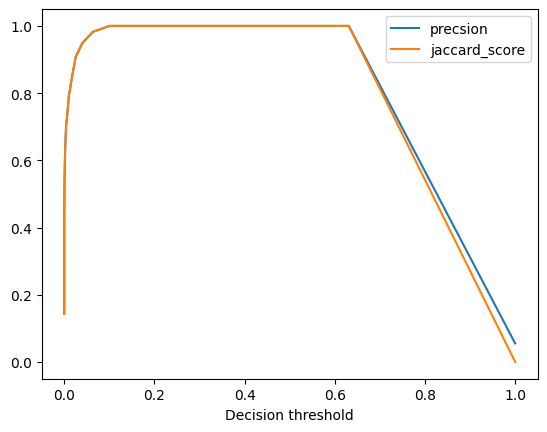

In [ ]:
tm_plot_threshold_test(threshold_test_use)

In [ ]:
max_config = threshold_test_use.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]
best_t

0.09999999999999346

In [ ]:
y_pred_use = use_model.predict(X_test_use_embedding)
y_pred_use = (y_pred_use > best_t).astype(np.float32)
precision_use      = average_precision_score(y_test_b, y_pred_use, average='micro')
jaccard_score_use = jaccard_score(y_test_b, y_pred_use, average='micro')


29/49 [================>.............] - ETA: 0s

49/49 [==============================] - 0s 2ms/step


In [ ]:
plot_confusion_matrix(y_test_b, y_pred_use, label_list)

# Evaluation 

In [ ]:
avg_precision_scores = [precision_w2v, precision_use,]
jaccard_scores = [jaccard_score_w2v, jaccard_score_use]
result = pd.DataFrame(
    {
        'average_precision_scores' : avg_precision_scores,
        'jaccard_scores' : jaccard_scores
    }, index = ['Word2Vec','USE']
)
result.to_csv(f"{output_dir}result_supervised2.csv")

In [ ]:
result

,average_precision_scores,jaccard_scores
Word2Vec,0.084533,0.111220
USE,0.471676,0.508555
